## Load Libs

In [ ]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import auc, roc_curve

from matplotlib import pyplot as plt
sns.set(style="white")

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import Concatenate
from keras.optimizers import Adam, Nadam
from keras import regularizers

classpath = os.path.abspath('..')
if classpath not in sys.path: sys.path.insert(0, classpath)

from solution import fe_functions as fn

%matplotlib inline

def plot_result(hist):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['acc'], label='acc')
    plt.plot(hist.history['val_acc'], label='val_acc')
    plt.title('Accuracy')

    plt.legend(loc='best')
    plt.show()
    
def draw_roc_curve(y, pred):
    from matplotlib import pyplot as plt

    fprRf, tprRf, _ = roc_curve(y, pred, pos_label=1)
    auc_scr = auc(fprRf, tprRf)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.show()

## Data Schema

Column name         | Description
				 ---|---
customerIDCustomer 	|	ID
genderCustomer  	|	gender (female, male)
SeniorCitizen    	|	Whether the customer is a senior citizen or not (1, 0)
Partner    			|	Whether the customer has a partner or not (Yes, No)
Dependents    		|	Whether the customer has dependents or not (Yes, No)
tenure				|	Number of months the customer has stayed with the company
PhoneService    	|	Whether the customer has a phone service or not (Yes, No)
MultipleLines    	|	Whether the customer has multiple lines or not (Yes, No, No phone service)
InternetService		|	Customer’s internet service provider (DSL, Fiber optic, No)
OnlineSecurity    	|	Whether the customer has online security or not (Yes, No, No internet service)
OnlineBackup    	|	Whether the customer has online backup or not (Yes, No, No internet service)
DeviceProtection   	|	Whether the customer has device protection or not (Yes, No, No internet service)
TechSupport    		|	Whether the customer has tech support or not (Yes, No, No internet service)
StreamingTV    		|	Whether the customer has streaming TV or not (Yes, No, No internet service)
StreamingMovies    	|	Whether the customer has streaming movies or not (Yes, No, No internet service)
contract 			|	The contract term of the customer (Month-to-month, One year, Two year)
PaperlessBilling    |	Whether the customer has paperless billing or not (Yes, No)
PaymentMethod		|	The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
MonthlyCharges		|	The amount charged to the customer monthly
TotalCharges		|	The total amount charged to the customer
churned				|	Whether the customer churned or not (Yes or No)

---

* 16個類別變數(customer id 不算)
* 3個numeric變數


---
<br/>
<br/>
<br/>

# Purpose: 
* 給定金融客戶Metadata, 繳費行為等等, 預測該客戶是否在未來有可能離開?

In [2]:
raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_telco_customer_churn.csv")
raw_vl = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_vl_telco_customer_churn.csv")
raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Drop 不必要的欄位

In [3]:
raw.drop(['customerID'], 1, inplace=True)
raw_vl.drop(['customerID'], 1, inplace=True)

## Data Clean: TotalCharges

* 讀取進來的時候因為有空字串, 導致於變成字串type, 需要轉型為float, 並且做missing value imputing
* Tansfer `Churn` [Yes, No] to [1, 0]

In [4]:
# TotalCharges 讀取進來的時候因為有missing value, 導致於變成字串type, 需要轉型為float, 並且做missing value imputing
def str2num(e):
    try:
        return float(e)
    except:
        return np.nan
              
tmp = raw.TotalCharges.map(str2num)
raw['TotalCharges'] = tmp.fillna(tmp.median())
raw['Churn'] = raw.Churn.map(lambda e: 1 if e == 'Yes' else 0)

tmp = raw_vl.TotalCharges.map(str2num)
raw_vl['TotalCharges'] = tmp.fillna(tmp.median())
raw_vl['Churn'] = raw_vl.Churn.map(lambda e: 1 if e == 'Yes' else 0)
del tmp

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 20 columns):
gender              5634 non-null object
SeniorCitizen       5634 non-null int64
Partner             5634 non-null object
Dependents          5634 non-null object
tenure              5634 non-null int64
PhoneService        5634 non-null object
MultipleLines       5634 non-null object
InternetService     5634 non-null object
OnlineSecurity      5634 non-null object
OnlineBackup        5634 non-null object
DeviceProtection    5634 non-null object
TechSupport         5634 non-null object
StreamingTV         5634 non-null object
StreamingMovies     5634 non-null object
Contract            5634 non-null object
PaperlessBilling    5634 non-null object
PaymentMethod       5634 non-null object
MonthlyCharges      5634 non-null float64
TotalCharges        5634 non-null float64
Churn               5634 non-null int64
dtypes: float64(2), int64(3), object(15)
memory usage: 880.4+ KB


## Features setting

In [6]:
catg_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PhoneService', 'MultipleLines', 'InternetService',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
# embedding_features = catg_features + ['binn_tenure', 'binn_MonthlyCharges', 'binn_TotalCharges']
label = 'Churn'

<br/>

---



## Base Feature Preprocessing

* Normalize ofr numeric features
* One Hot Encoding for categorical features

In [7]:
def feature_engineering(raw, is_train=True, status=None):
    data = raw.copy()
    
    if is_train:
        status = {'scaler': None, 
                  'mapper': defaultdict(LabelBinarizer),
                  'woe_mapper': {},
                  'binn_mapper': {},
                  'freq_mapper': {},
                  'mean_mapper': {}}

    catg_ftrs = catg_features.copy()
        
    # Numeric binning to categorical features
    do_binning(catg_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    catg_part = pd.DataFrame()
    
    # One Hot Encoding
    # catg_part = pd.get_dummies(data[catg_ftrs])
    do_onehot(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Embedding, simple indexing categorical features, actual embedding function in keras
    # do_embedding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # WOE encoding
    do_woe_encoding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Frequency encoding, target mean encoding
    do_target_encoding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Normalize
    num_part = do_norm(num_features, status, data, is_train)
    # -----------------------------------------------------------------------------------------
    
    # Merge categorical, numeric features
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['Churn'].copy()
    
    # Include quadratic term, cube term
    do_nth_order_polynominal(num_features, data_x)
    # ----------------------------------------------------------------------------------------- 
    return data_x, data_y, status


# # import fe_functions as fn
# do_onehot = fn.do_onehot
# do_norm = fn.do_norm
# do_embedding = fn.do_embedding
# do_binning = fn.do_binning
# do_woe_encoding = fn.do_woe_encoding
# do_target_encoding = fn.do_target_encoding
# do_nth_order_polynominal = fn.do_nth_order_polynominal

## Functions of Features Processing

In [8]:
def do_binning(catg_ftrs, status, data, is_train):
#     def quartile_binning(x):
#         bins = np.percentile(x, range(0, 100, 25))[1:].tolist()
#         iqr_x_150 = (bins[-1] - bins[0]) * 1.5
#         bins = [bins[0] - iqr_x_150] + bins + [bins[-1] + iqr_x_150]
#         result = pd.Series(np.digitize(x, bins)).map(pd.Series([0, 1, 2, 3, 4, 0])).values
#         return result, bins
#     for col in ('tenure', 'MonthlyCharges', 'TotalCharges'):
#         binned_name = f'binn_{col}'
#         if is_train:
#             result, bins = quartile_binning(data[col])
#             status['binn_mapper'][binned_name] = bins
#             data[binned_name] = result
#         else:
#             bins = status['binn_mapper'][binned_name]
#             data[binned_name] = pd.Series(np.digitize(data[col], bins))\
#                                   .map(pd.Series([0, 1, 2, 3, 4, 0])).values
#         catg_ftrs.append(binned_name)
    pass

def do_onehot(catg_ftrs, catg_part, status, data, is_train):
    mapper = status['mapper']
    tmp = []
    for catg_col in catg_ftrs:
        if is_train:
            result = mapper[catg_col].fit_transform(data[catg_col])
        else:
            result = mapper[catg_col].transform(data[catg_col])

        columns = [f'{catg_col}_{col}' for col in mapper[catg_col].classes_]
        if result.shape[1] == 1:
            columns = columns[:1]
        tmp.append(pd.DataFrame(data=result, columns=columns))
    tmp = pd.concat(tmp, 1)
    for col in tmp:
        catg_part[col] = tmp[col]
    pass

def do_woe_encoding(catg_ftrs, catg_part, status, data, is_train):
#     def woe_encode(x, label, data):
#         """Calculate the Weight of Evidence of given categorical feature and label

#         :param x: Given feature name
#         :param label: Label name
#         :param data:
#         :return: WOE encoded dictionary
#         """
#         total_vc = data[label].value_counts().sort_index()

#         def woe(pipe, total_vc):
#             # Count by label in this group
#             group_vc = pipe[label].value_counts().sort_index()

#             # Some class in the feature is missing, fill zero to missing class
#             if len(group_vc) < len(total_vc):
#                 for key in total_vc.index:
#                     if key not in group_vc:
#                         group_vc[key] = 0.
#                 group_vc = group_vc.sort_index()

#             # WOE formula
#             r = ((group_vc + 0.5) / total_vc).values

#             # Odd ratio => 1 to 0, you can define meaning of each class
#             return np.log(r[1] / r[0])

#         return data.groupby(x).apply(lambda pipe: woe(pipe, total_vc))

#     for catg_col in catg_ftrs:
#         if is_train:
#             kv = woe_encode(catg_col, 'Churn', data)
#             status['woe_mapper'][catg_col] = kv.to_dict()
#         else:
#             kv = pd.Series(status['woe_mapper'][catg_col])
#         catg_part[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    pass

def do_target_encoding(catg_ftrs, catg_part, status, data, is_train):
#     for catg_col in catg_ftrs:
#         if is_train:
#             freq_proportion = data[catg_col].value_counts() / len(data)
#             catg_part[f'freq_{catg_col}'] = freq_proportion.reindex(data[catg_col]).values
#             target_mean = data.groupby(catg_col).Churn.mean()
#             catg_part[f'mean_{catg_col}'] = target_mean.reindex(data[catg_col]).values

#             status['freq_mapper'][catg_col] = freq_proportion.to_dict()
#             status['mean_mapper'][catg_col] = target_mean.to_dict()
#         else:
#             catg_part[f'freq_{catg_col}'] = pd.Series(status['freq_mapper'][catg_col]).reindex(data[catg_col]).values
#             catg_part[f'mean_{catg_col}'] = pd.Series(status['mean_mapper'][catg_col]).reindex(data[catg_col]).values
    pass

def do_norm(num_features, status, data, is_train):
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        status['scaler'] = scaler
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        scaler = status['scaler']
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    return num_part
    pass

def do_nth_order_polynominal(num_features, data):
#     for num_col in num_features:
#         data[f'{num_col}_degree_2'] = data[num_col] ** 2
#         data[f'{num_col}_degree_3'] = data[num_col] ** 3
    pass

## Model on Base Featue Engineering

* Network Structure: 
    * `dimension of input, 32, 16, 16, 1`
* ReLU Activation Function
* Adam Optimizer
* Sigmoid Cross Entropy

In [9]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [10]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(5634, 40) (1409, 40)


,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,-1.273098,-1.155973,-0.990447
1,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,1,0.072520,-0.253553,-0.166213
2,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,-1.232322,-0.356781,-0.955743
3,1,0,0,0,0,0,1,1,0,0,...,1,0,0,1,0,0,0,0.521060,-0.741392,-0.187820
4,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,-1.232322,0.204318,-0.936463


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,129
Trainable params: 2,129
Non-trainable params: 0
_________________________________________________________________
Train on 5634 samples, validate on 1409 samples
Epoch 1/30
5634/5634 [==============================] - 1s 114us/step - loss: 0.6431 - acc: 0.7293 - val_loss: 0.5110 - val_acc: 0.7452
Epoch 2/30
5634/5634 [==============================] - 0s 42us/step - loss: 0.4626 - ac

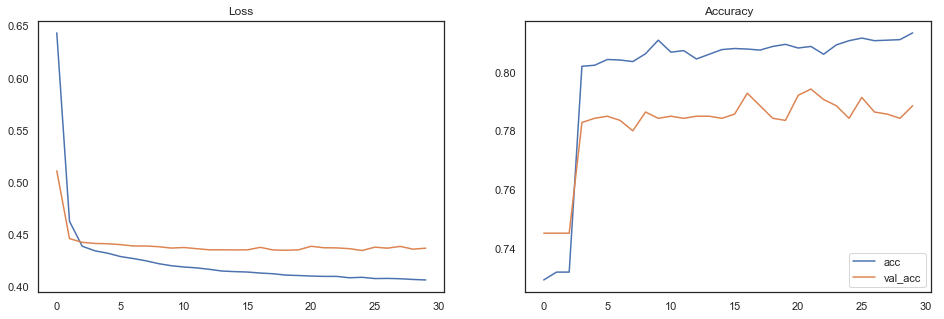

auc: 0.8219273113144978


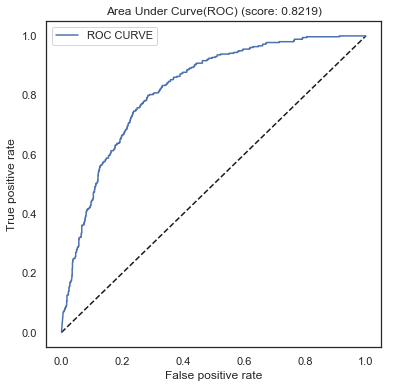

In [12]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

## Bining Numeric Feature: Age, Balance, CreditScore

* `Age` Interquartile cut
* `Balance` Binary cut => 0 if  `Balance = 0` else 1
* `CreditScore` Deciles cut


In [ ]:
def do_binning(catg_ftrs, status, data, is_train):
    def quartile_binning(x):
        bins = np.percentile(x, range(0, 100, 25))[1:].tolist()
        iqr_x_150 = (bins[-1] - bins[0]) * 1.5
        bins = [bins[0] - iqr_x_150] + bins + [bins[-1] + iqr_x_150]
        result = pd.Series(np.digitize(x, bins)).map(pd.Series([0, 1, 2, 3, 4, 0])).values
        return result, bins

    for col in ('tenure', 'MonthlyCharges', 'TotalCharges'):
        binned_name = f'binn_{col}'
        if is_train:
            result, bins = quartile_binning(data[col])
            status['binn_mapper'][binned_name] = bins
            data[binned_name] = result
        else:
            bins = status['binn_mapper'][binned_name]
            data[binned_name] = pd.Series(np.digitize(data[col], bins))\
                                  .map(pd.Series([0, 1, 2, 3, 4, 0])).values

        catg_ftrs.append(binned_name)
    pass

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

## Model (Binning)

In [ ]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=60)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

In [ ]:
vl_y.value_counts()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print( confusion_matrix(vl_y, model.predict(vl_x) > .5) )
# draw_roc_curve(vl_y, model.predict(vl_x))

In [ ]:
sns.lineplot(range(len(vl_x)), pd.Series(model.predict(vl_x).ravel()).sort_values())

In [ ]:
help(confusion_matrix)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0], labels=[1, 0]))
print(classification_report([0, 1, 0, 1], [1, 1, 1, 0]))

[[1 1]
 [2 0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.33      0.50      0.40         2

avg / total       0.17      0.25      0.20         4



## Add Weight of Evidence Encoding

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

## Model (WOE)

In [ ]:
K.clear_session()

model = get_model(input_dim=56)
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

## Statistical Encoding, Target Encoding

* Frequency encoding
* Mean encoding

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding)

In [ ]:
K.clear_session()

model = get_model(input_dim=130)
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

## Add Polynomial Featue Engineering

* Add quradratic, cube term base on numeric features

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding + Polynominal)

In [ ]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
tr_x_pca = pca.fit_transform(tr_x)
vl_x_pca = pca.transform(vl_x)

In [ ]:
K.clear_session()

model = get_model(input_dim=tr_x_pca.shape[1])
hist = model.fit(tr_x_pca, tr_y, validation_data=(vl_x_pca, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x_pca))

## Model (AutoEncoder)

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

In [ ]:
K.clear_session()

inputs_dim = tr_x.shape[1]

inputs = Input(shape=(inputs_dim, ))
# Encoder
encoded = Dense(inputs_dim, activation='selu')(inputs)
encoded = Dense(64, activation='selu')(encoded)
encoded = Dense(64, activation='selu')(encoded)
encoded = Dense(128, activation='selu')(encoded)

# Decoder
decoded = Dense(128, activation='selu')(encoded)
decoded = Dense(64, activation='selu')(decoded)
decoded = Dense(64, activation='selu')(decoded)
decoded = Dense(inputs_dim, activation='linear')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs, decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs, encoded)

# Adam Optimizer + Mean square error loss
autoencoder.compile(optimizer='adam', loss='mse')
hist = autoencoder.fit(
    tr_x, tr_x, 
    epochs=100, 
    batch_size=200, 
    shuffle=True, 
    validation_data=(vl_x, vl_x))

def plot_ae(hist):
    plt.figure(figsize=(16, 5))
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')
    plt.legend(loc='best')
    plt.show()
    
plot_ae(hist)

In [ ]:
tr_x_ae = encoder.predict(tr_x)
vl_x_ae = encoder.predict(vl_x)

In [ ]:
tr_x_ae.shape

In [ ]:
K.clear_session()

model = get_model(input_dim=tr_x_ae.shape[1])
hist = model.fit(tr_x_ae, tr_y, validation_data=(vl_x_ae, vl_y), batch_size=100, epochs=30)

plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x_ae))